In [1]:
# IMPORTS
import os
from datasets import Audio, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import set_seed as t_set_seed
import torch
import torch.nn as nn
from torchvision import transforms
import torchaudio 
import torchaudio.transforms as T
import numpy as np
from datasets import Dataset
import random
from PIL import Image, ImageOps
import evaluate
from transformers import EvalPrediction
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import shutil, os
import librosa

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    #random.seed(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    t_set_seed(seed)

In [ ]:
# PARAMETERS
training_size = int(input("Enter the amount of spectrograms per class to train on (default 100): ") or 100)
segments_path = "./segments"
output_dir = "./vit-base-manuai" # Fine-tuned model output directory

model_name = "google/vit-base-patch16-224-in21k"
if os.path.exists("./manuai_checkpoints/preprocessor_config.json"): # If the model has already been fine-tuned, use that as the base (previous checkpoints)
    model_name = "./manuai_checkpoints"

processor = ViTImageProcessor.from_pretrained(model_name)  # Use the processor from the pre-trained model
sample_rate = 22050
epochs = 30
batch_size = 16
n_proc = 2  # Number of processes for parallel processing
seed = 42
lora_rank = 16
image_size = 224  # ViT base model image size

training_args = TrainingArguments(
    output_dir="./manuai_checkpoints", 
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=False, 
    bf16=False,
    logging_steps=100,
    report_to="tensorboard",
    save_total_limit=3,
)
set_seed(seed)

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Set up dataset
Defines the labels
Load all files
Assign ID to labels
Create dataset of `training_size` per specie, and augment if not enough samples.

In [4]:
# IMPORT DATA
def apply_augmentation(waveform, sr):
    augmentations = [
        lambda x: x + 0.005 * torch.randn_like(x),  # Noise
        lambda x: T.Vol(gain=random.uniform(-5, 5), gain_type="db")(x),  # Gain
    ]
    num_transforms = random.choice([1, 2])
    chosen = random.sample(augmentations, num_transforms)
    for transform in chosen:
        waveform = transform(waveform)
    return waveform

def augment_imbalance():
    """
    Augment the dataset to address class imbalance.
    """
    augment_count = 0
    for label in labels:
        files = files_labels[label]
        random.shuffle(files)
        selected_files = files[:training_size]
        # Add original files
        for file_path in selected_files:
            waveform, sr = torchaudio.load(file_path)
            if sr != sample_rate:
                waveform = T.Resample(sr, sample_rate)(waveform)
                sr = sample_rate
            yield {
                "audio": {"array": waveform.squeeze().numpy(), "sampling_rate": sr},
                "label": label_to_id[label]
            }
        # Augment if not enough originals
        num_to_augment = training_size - len(selected_files)
        if num_to_augment > 0:
            for _ in range(num_to_augment):
                file_path = random.choice(selected_files)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    waveform = T.Resample(sr, sample_rate)(waveform)
                    sr = sample_rate
                augmented_waveform = apply_augmentation(waveform, sr)
                yield {
                    "audio": {"array": augmented_waveform.squeeze().detach().numpy().astype(np.float32), "sampling_rate": sr},
                    "label": label_to_id[label]
                }
            print(f"Augmented {num_to_augment} samples for label: {label}")
        else:
            print(f"No augmentation needed for label: {label}")
    print(f"Augmented {augment_count} samples overall.")

labels = sorted(os.listdir(segments_path))
label_to_id = {lbl: i for i, lbl in enumerate(labels)}
id_to_label = {i: lbl for lbl, i in label_to_id.items()}

# Collect original files by label
files_labels = {label: [] for label in labels}
for root, dirs, files in os.walk(segments_path):
    for file in files:
        if file.endswith(".wav"):
            label = os.path.splitext(file)[0].split('_')[1]
            files_labels[label].append(os.path.join(root, file))

dataset = Dataset.from_generator(augment_imbalance)

print("Final label order:", labels)

if dataset:
    print(f"✅ Dataset created successfully with {len(dataset)} samples.")
else:
    print("❌ Dataset creation failed.")

Generating train split: 0 examples [00:00, ? examples/s]/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
Generating train split: 1099 examples [00:01, 621.95 examples/s]

No augmentation needed for label: bellbird


Generating train split: 2028 examples [00:02, 668.44 examples/s] 

No augmentation needed for label: fantail


Generating train split: 3079 examples [00:03, 745.77 examples/s] 

No augmentation needed for label: kaka


Generating train split: 3999 examples [00:04, 929.51 examples/s] 

Augmented 281 samples for label: morepork


Generating train split: 5107 examples [00:05, 796.72 examples/s] 

No augmentation needed for label: robin


Generating train split: 6015 examples [00:06, 740.07 examples/s] 

Augmented 38 samples for label: saddleback


Generating train split: 7083 examples [00:07, 793.87 examples/s] 

No augmentation needed for label: silvereye


Generating train split: 8086 examples [00:08, 729.35 examples/s] 

Augmented 149 samples for label: tomtit


Generating train split: 9077 examples [00:09, 785.86 examples/s] 

No augmentation needed for label: tui


Generating train split: 10000 examples [00:10, 965.33 examples/s]

No augmentation needed for label: whitehead
Augmented 0 samples overall.


Final label order: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
✅ Dataset created successfully with 10000 samples.


# Generate and plot spectrograms

Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3

Generated 10000 mel spectrograms.
{'label': Value('int64'), 'pixel_values': List(List(List(Value('float16'))))}
Data ready for training.


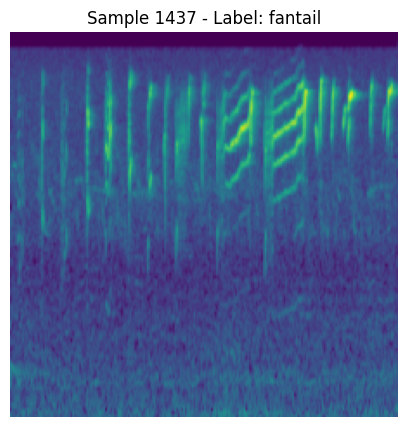

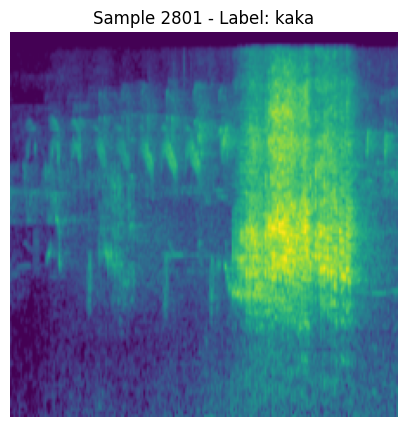

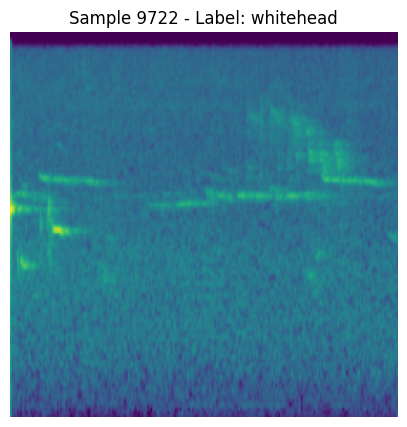

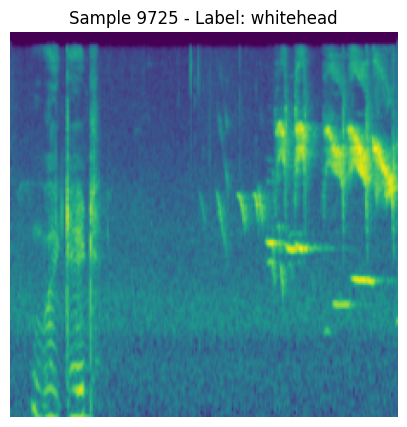

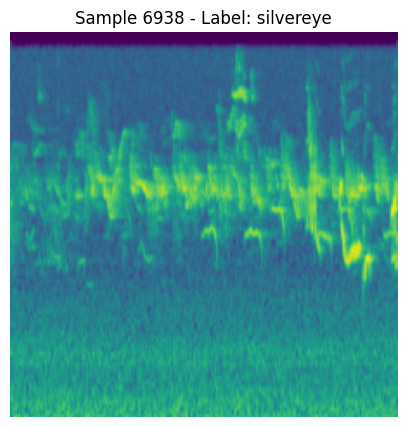

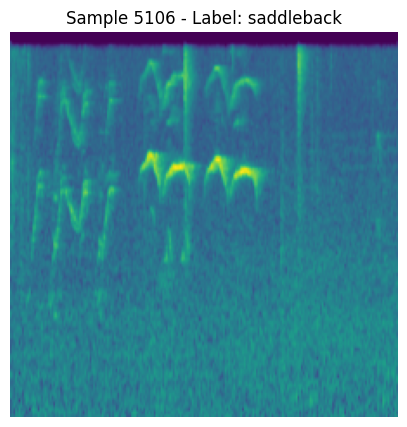

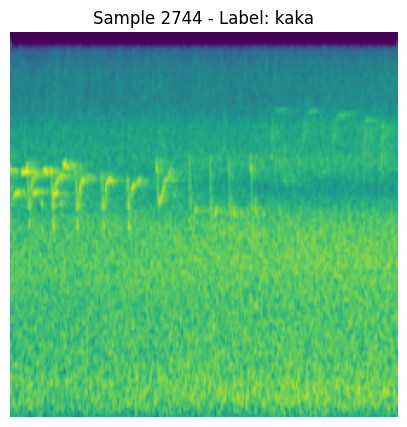

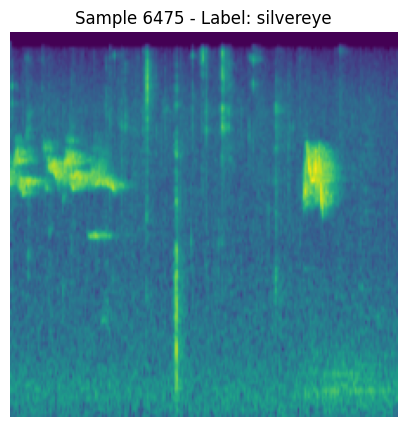

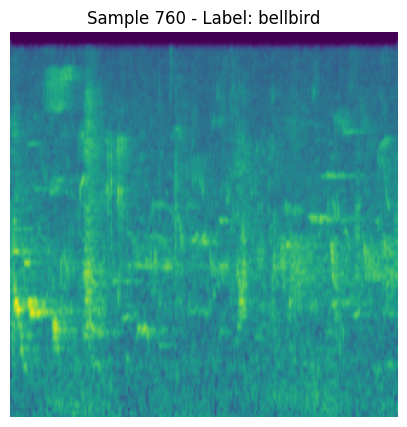

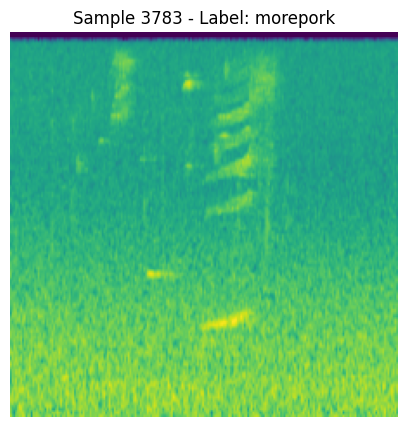

In [5]:
# CONVERT AUDIO TO MEL SPECTROGRAMS
spectrogram_mode = "log-mel"
def convert_to_mel_spectrogram(batch):
    audio = batch["audio"]
    waveform = torch.tensor(audio["array"], dtype=torch.float32)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)  # make it (1, time)

    mel_spec = T.MelSpectrogram(
        sample_rate=audio["sampling_rate"],
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        n_mels=128,
        f_min=200,
        f_max=12000,
    )(waveform)

    mel_spec = mel_spec.squeeze(0).detach().cpu().numpy()

    # --- Create log-mel spectrogram ---
    if spectrogram_mode == "log-mel":
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        y = log_mel
    elif spectrogram_mode == "delta3":
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        delta = librosa.feature.delta(log_mel)
        delta2 = librosa.feature.delta(log_mel, order=2)
        y = np.stack([log_mel, delta, delta2], axis=-1)  # (H, W, 3)
    elif spectrogram_mode == "pcen":
        y = librosa.pcen(mel_spec * (2**31))
    else:
        raise ValueError(f"Unknown spectrogram_mode: {spectrogram_mode}")

    # Normalise for training
    y_norm = (y - y.mean()) / (y.std() if y.std() > 0 else 1.0)

    # Ensure 3 channels for ViT
    if y_norm.ndim == 2:  # single-channel
        y_model = np.stack([y_norm]*3, axis=0)  # (3, H, W)
        y_plot  = np.stack([y]*3, axis=-1)      # (H, W, 3)
    elif y_norm.ndim == 3:
        if y_norm.shape[2] == 1:
            y_model = np.repeat(y_norm, 3, axis=2).transpose(2,0,1)
        else:
            y_model = y_norm.transpose(2,0,1)  # (C,H,W)
        y_plot = y  # (H,W,C)

    y_model = torch.tensor(y_model)
    y_model = torch.nn.functional.interpolate(y_model.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False)
    y_model = y_model.squeeze(0).numpy().astype(np.float16)

    return {
        "pixel_values": y_model,
    }

def augment_spectrogram(spectrogram, time_mask_max=20, freq_mask_max=10, num_time_masks=1, num_freq_masks=1):
    """
    Apply SpecAugment-style masking to a spectrogram.
    """
    y = spectrogram.copy()
    
    H, W = y.shape[:2]
    
    # Apply frequency masks
    for _ in range(num_freq_masks):
        f = random.randint(0, freq_mask_max)
        f0 = random.randint(0, max(H - f, 1))
        if y.ndim == 2:
            y[f0:f0+f, :] = 0
        else:
            y[f0:f0+f, :, :] = 0
    
    # Apply time masks
    for _ in range(num_time_masks):
        t = random.randint(0, time_mask_max)
        t0 = random.randint(0, max(W - t, 1))
        if y.ndim == 2:
            y[:, t0:t0+t] = 0
        else:
            y[:, t0:t0+t, :] = 0
    
    return y

dataset = dataset.map(
    convert_to_mel_spectrogram,
    remove_columns=["audio"],
    num_proc=n_proc,
)

print(f"Generated {len(dataset)} mel spectrograms.")
print(dataset.features)
print("Data ready for training.")

# Display 10 random spectrograms and their labels (and save to spectrograms/)
for i in random.sample(range(len(dataset)), 10):
    arr = dataset[i]["pixel_values"]
    img = arr[0]
    plt.figure(figsize=(5,5))
    plt.imshow(img, aspect="auto", origin="lower")
    plt.title(f"Sample {i} - Label: {id_to_label[dataset[i]['label']]}")
    plt.axis("off")
    if not os.path.exists("spectrograms"):
        os.makedirs("spectrograms")
    plt.savefig(f"spectrograms/spectrogram_{i}_{id_to_label[dataset[i]['label']]}.png")
    plt.show()

# Set up Model architecture

In [ ]:
# SET UP MODEL

def trainable_parameters(model):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    return f"{model.__class__.__name__} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)"

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Overall metrics
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    prec = precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"]
    rec = recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]

    # Per-class accuracy / precision / recall
    class_acc = {}
    class_prec = {}
    class_rec = {}
    num_classes = len(np.unique(labels))
    for i in range(num_classes):
        idx = labels == i
        class_acc[i] = (preds[idx] == labels[idx]).mean()
        class_prec[i] = precision_metric.compute(predictions=preds, references=labels, average=None)["precision"][i]
        class_rec[i] = recall_metric.compute(predictions=preds, references=labels, average=None)["recall"][i]


    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        #"class_accuracy": class_acc,
        #"class_precision": class_prec,
        #"class_recall": class_rec,
    }

train, test = dataset.train_test_split(test_size=0.2).values()
dataset = DatasetDict({"train": train, "test": test})

# Model Architecture
processor = ViTImageProcessor.from_pretrained(model_name)
callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
base_model = ViTForImageClassification.from_pretrained(
    model_name, 
    num_labels=len(labels),
    id2label=id_to_label,
    label2id=label_to_id
)
lora = LoraConfig(
    r=lora_rank,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"], # "dense" is another option (all connected layers)
    modules_to_save=["classifier"]
)

model = get_peft_model(base_model, lora)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    processing_class=processor,
    callbacks=callbacks
)

print("Labels & IDs:")
for i, label in enumerate(labels):
    print(f"{label}: {i}")

print(trainable_parameters(model))
print("Ready to begin training...")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Labels & IDs:
bellbird: 0
fantail: 1
kaka: 2
morepork: 3
robin: 4
saddleback: 5
silvereye: 6
tomtit: 7
tui: 8
whitehead: 9
PeftModel trainable parameters: 892,426/86,698,772 (1.03%)
Ready to begin training...


# Train the model

In [ ]:
# TRAIN MODEL
result = trainer.train()
trainer.log_metrics("train", result.metrics)
trainer.save_metrics("train", result.metrics)
trainer.save_model()  # Saves the tokenizer too for easy upload
trainer.save_state() # Save the trainer state

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.162000,2.119628,0.382500,0.404352,0.382500,0.367103


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


# Evaluate the model

In [ ]:
# EVALUATE MODEL
metrics = trainer.evaluate(eval_dataset=dataset["test"])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

# Check metrics of fine-tuned model

In [ ]:
# MODEL METRIC EVALUATION REPORT

# Overall 
print(metrics)
print(f"Overall accuracy: {metrics['eval_accuracy']:.2f}")
print(f"Overall precision: {metrics['eval_precision']:.2f}")
print(f"Overall recall: {metrics['eval_recall']:.2f}")
print(f"Overall F1 Score: {metrics['eval_f1']:.2f}")

predictions = trainer.predict(dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

accuracy_per_class = {}
for i, label_name in enumerate(labels):
    idx = (y_true == i) 
    accuracy_per_class[label_name] = (y_pred[idx] == y_true[idx]).mean()

print("Accuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"{label}: {acc:.2f}")

print(f"Precision & Recall per class")
for i, label_name in enumerate(labels):
    precision = precision_score(y_true, y_pred, average=None)[i]
    recall = recall_score(y_true, y_pred, average=None)[i]
    print(f"{label_name}: Precision: {precision:.2f}, Recall: {recall:.2f}")

# Confusion Matrix (plot)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("train size:", len(dataset["train"]))
print("eval size:", len(dataset["test"]))
print("training args per_device_train_batch_size:", training_args.per_device_train_batch_size)
print("trainer.state.max_steps:", trainer.state.max_steps)
print("trainer.state.global_step:", trainer.state.global_step)

In [ ]:
model.save_pretrained("./manuai_lora_adapter")  # saves only PEFT weights + config
# load later with
# from peft import PeftModel, PeftConfig
# model = ViTForImageClassification.from_pretrained(base_model)
# model = PeftModel.from_pretrained(model, "./manuai_lora_adapter")

# ZIP fine-tuned model

In [ ]:
# ZIP LORA FINETUNED MODEL
!zip -r manuai-lora-10.zip manuai_lora_adapter/